<a href="https://colab.research.google.com/github/ShwetaBaranwal/PyTorch_Basics/blob/master/PyTorch_basics_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import trange, tqdm_notebook, tqdm


Reading data file:

In [0]:
data = pd.read_csv("./sample_data/mnist_train_small.csv", header=None)

In [0]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Forming labels and images array:

In [0]:
labels = np.array(data[[0]])
print(labels.shape)

(20000, 1)


In [0]:
images_arr = np.array(data[[i for i in range(1,785)]]).reshape((20000, 1, 28, 28))
print(images_arr.shape)

(20000, 1, 28, 28)


Sample of image:

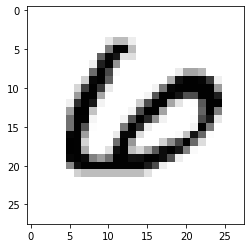

In [0]:
plt.imshow(np.squeeze(images_arr[0], axis=0), cmap="binary")

In [0]:
labels[0]

array([6])

Train Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(images_arr, labels, test_size=0.33, random_state=42)

In [0]:
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13400, 1, 28, 28)
(6600, 1, 28, 28)
(13400, 1)
(6600, 1)


Model:

In [0]:
class MNISTmodel(nn.Module):  #nn.module is parent class
  def __init__(self):  
    super(MNISTmodel, self).__init__()   #nn.module charactistics
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 16, 3)
    self.maxpool = nn.MaxPool2d(2, stride=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8464, 100) 
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x))
    return x


In [0]:
net = MNISTmodel()

In [0]:
print(net)

MNISTmodel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=8464, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [0]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[0.0965, 0.1125, 0.0848, 0.0963, 0.0880, 0.1041, 0.1072, 0.0949, 0.1181,
         0.0977]], grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Model Dataset:

In [0]:
class MNISTDataset(Dataset): #Dataset parent class
    """MNIST dataset."""

    def __init__(self, arr, lbl):
        """
        Args:
        arr (array): image array size = (20000,1,28,28)
        lbl (int): image lable between 0 to 9
        
        """
        self.image_array = arr  #(20k,1,28,28)
        self.labels = lbl #(20k,1) 

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):   #0 to 20K: idx
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()

        img_arr = self.image_array[idx]
        img_label = self.labels[idx]

        return img_arr, img_label    

In [0]:
mnist_train_dataset = MNISTDataset(X_train, y_train)
mnist_test_dataset = MNISTDataset(X_test, y_test)

In [0]:
(mnist_train_dataset[0][0]).shape

(1, 28, 28)

In [0]:
train_dataloader = DataLoader(mnist_train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(mnist_test_dataset, batch_size=4, shuffle=False)

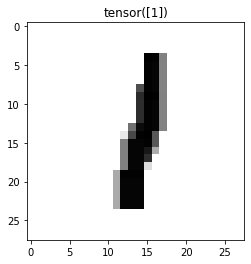

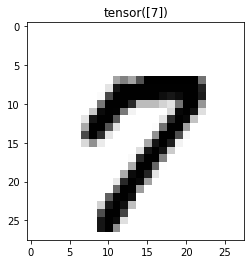

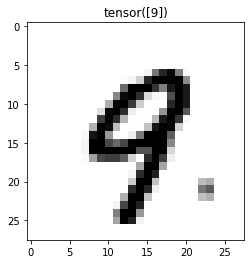

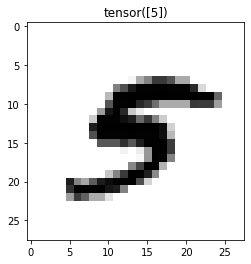

In [0]:
#displaying a batch
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
for i in range(len(labels)):
  plt.figure()
  plt.imshow(np.squeeze(images[i], axis=0), cmap= "binary")
  plt.title(labels[i])

In [0]:
labels.shape

torch.Size([4, 1])

Model training:

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
#defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [0]:
net = net.to(device)  #puts in GPU

In [0]:
net.train()

for epoch in trange(2):
  for i, b in tqdm_notebook(enumerate(train_dataloader), desc = "Training"):

    # get the inputs; data is a list of [inputs, labels]
    x = torch.tensor(b[0], dtype = torch.float).to(device, dtype = torch.float)
    y = torch.tensor(b[1], dtype = torch.long).to(device, dtype = torch.long)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = net(x)
    loss = criterion(output, y.view(-1))   #crossentropy 
    loss.backward()  #back propogation
    optimizer.step()   #update grad

  print (f"loss: {loss}")

  


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
 50%|█████     | 1/2 [00:08<00:08,  8.06s/it]


loss: 2.4611501693725586


100%|██████████| 2/2 [00:15<00:00,  8.00s/it]


loss: 2.4611501693725586


Model Evaluation:

In [0]:
net.eval()
eval_loss = 0
eval_steps = 0
preds = None 
out_label_ids = None
for i, b in tqdm_notebook(enumerate(test_dataloader), desc = "Evaluating"):

  # get the inputs; data is a list of [inputs, labels]
  x = torch.tensor(b[0], dtype = torch.float).to(device, dtype = torch.float)
  y = torch.tensor(b[1], dtype = torch.long).to(device, dtype = torch.long)

  #set to no gradient computation
  with torch.no_grad():
    output = net(x)
    loss = criterion(output, y.view(-1))    true: (1),  pred: np.array(#len_classs)

  # computing eval loss
  eval_loss += loss.mean().item()
  eval_steps += 1

  #saving true and predicted labels
  if preds is None:
      preds = output.detach().cpu().numpy()   #detaching from gpu to cpu
      out_label_ids = y.detach().cpu().numpy()
  else:
    preds = np.append(preds, output.detach().cpu().numpy(), axis=0)
    out_label_ids = np.append(out_label_ids, y.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss/eval_steps
preds = np.argmax(preds, axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
eval_loss

2.3591804724028616

In [0]:
preds

array([9, 9, 9, ..., 9, 9, 9])

In [0]:
out_label_ids

array([[9],
       [5],
       [2],
       ...,
       [5],
       [8],
       [9]])